# Resource

https://learn.microsoft.com/en-us/training/modules/intro-audio-classification-pytorch/1-introduction

# Configurations

In [ ]:
data_path = '/content/drive/MyDrive/COIN Seminar/data'
notebook_path = '/content/drive/MyDrive/COIN Seminar/notebooks'
tmp_path = '/content/tmp'

use_mffc = False

spectrogram_path_beti = f'{data_path}/spectrograms_beti'
spectrogram_path_kisha = f'{data_path}/spectrograms_kisha'
mfccs_path_beti = f'{data_path}/mfccs_beti'
mfccs_path_kisha = f'{data_path}/mfccs_kisha'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports

In [ ]:
# util
import os, tempfile
import sys
import time
from pathlib import Path
from itertools import chain
import numpy as np
from functools import partial
from tqdm.auto import tqdm
import pandas as pd

# pytorch
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# ray tune
!pip install -U "ray[tune, train]"
from ray import train, tune
import ray.cloudpickle as pickle
from ray.train import Checkpoint, session
from ray.tune.schedulers import ASHAScheduler

# sklearn
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display

# Load audio data

In [ ]:
from typing import List

def load_audio_files(paths: List[str], label:str):

    dataset = []

    for path in paths:
      walker_wav = sorted(str(p) for p in Path(path).glob(f'*.wav'))
      walker_mp3 = sorted(str(p) for p in Path(path).glob(f'*.mp3'))

      for i, file_path in enumerate(list(chain(walker_wav, walker_mp3))):
          path, filename = os.path.split(file_path)

          # Load audio
          waveform, sample_rate = torchaudio.load(file_path)
          dataset.append([waveform, sample_rate, label])

    return dataset

In [ ]:
# Meow
base_meow_path = f'{data_path}/Meowing'

trainset_meow_angry = load_audio_files([f'{base_meow_path}/AngryV2'], 'meow_angry')
trainloader_meow_angry = torch.utils.data.DataLoader(trainset_meow_angry, batch_size=1,shuffle=True, num_workers=0)

trainset_meow_happy = load_audio_files([f'{base_meow_path}/Happy'], 'meow_happy')
trainloader_meow_happy = torch.utils.data.DataLoader(trainset_meow_happy, batch_size=1,shuffle=True, num_workers=0)

trainset_meow_sad = load_audio_files([f'{base_meow_path}/Sad'], 'meow_sad')
trainloader_meow_sad = torch.utils.data.DataLoader(trainset_meow_sad, batch_size=1,shuffle=True, num_workers=0)

#trainset_meow_scared = load_audio_files([f'{base_meow_path}/Scared'], 'meow_scared')
#trainloader_meow_scared = torch.utils.data.DataLoader(trainset_meow_scared, batch_size=1,shuffle=True, num_workers=0)

In [ ]:
# Meow
trainset_meow = trainset_meow_angry + trainset_meow_happy + trainset_meow_sad #+ trainset_meow_scared
trainloader_meow = torch.utils.data.DataLoader(trainset_meow, batch_size=1,shuffle=True, num_workers=0)

# Purr
trainset_purr = load_audio_files([f'{data_path}/Purring'], 'purr')
trainloader_purr = torch.utils.data.DataLoader(trainset_purr, batch_size=1,shuffle=True, num_workers=0)

# Hiss
trainset_hiss = load_audio_files([f'{data_path}/Hissing'], 'hiss')
trainloader_hiss = torch.utils.data.DataLoader(trainset_hiss, batch_size=1,shuffle=True, num_workers=0)

# Chirp
trainset_chirp = load_audio_files([f'{data_path}/Chirping'], 'chirp')
trainloader_chirp = torch.utils.data.DataLoader(trainset_purr, batch_size=1,shuffle=True, num_workers=0)

# Create spectrograms

In [ ]:
def create_spectrogram_images(trainloader, spectrogram_path, label_dir):
    directory = f'{spectrogram_path}/{label_dir}'

    if not os.path.isdir(directory):
        os.makedirs(directory, mode=0o777, exist_ok=True)

    for i, data in enumerate(trainloader):

      # this is probably not the best solution it would be better to remove these passages in the audio that create 0 values
      # apply very small offset so no zeros are in the waveform since the log(0) = -inf and -inf causes
      # problems when saving the spectrogram
      waveform = data[0] + 1e-9

      # create transformed waveforms
      spectrogram_tensor = torchaudio.transforms.Spectrogram()(waveform)
      spectrogram_numpy = spectrogram_tensor.log2()[0,:,:].numpy()
      filter = spectrogram_numpy != np.NINF
      filtered_spectrogram = np.where(filter, spectrogram_numpy, sys.float_info.min) # replace remaining -inf with smallest float

      plt.figure()
      plt.imsave(f'{directory}/spec_img{i}.png', filtered_spectrogram, cmap='viridis')
      plt.close()

In [ ]:
# Spectrograms for first model
create_spectrogram_images(trainset_meow, spectrogram_path_beti, 'meow')
create_spectrogram_images(trainset_purr, spectrogram_path_beti, 'purr')
create_spectrogram_images(trainset_hiss, spectrogram_path_beti, 'hiss')
create_spectrogram_images(trainset_chirp, spectrogram_path_beti, 'chirp')

In [ ]:
# Spectrograms for second model
create_spectrogram_images(trainset_meow_angry, spectrogram_path_kisha, 'angry')
create_spectrogram_images(trainset_meow_happy, spectrogram_path_kisha, 'happy')
create_spectrogram_images(trainset_meow_sad, spectrogram_path_kisha, 'sad')
#create_spectrogram_images(trainset_meow_scared, spectrogram_path_kisha, 'scared')

# Create MFCCs

In [ ]:
def create_mfcc_images(trainloader, mfcc_path, label_dir):
    directory = f'{mfcc_path}/{label_dir}'

    if not os.path.isdir(directory):
        os.makedirs(directory, mode=0o777, exist_ok=True)

    for i, data in enumerate(trainloader):

        waveform = data[0] + 1e-9
        sample_rate = data[1][0]

        mfcc_spectrogram_tensor = torchaudio.transforms.MFCC(sample_rate= sample_rate)(waveform)
        mfcc_spectrogram_numpy = mfcc_spectrogram_tensor[0].log2()[0, :, :].numpy()
        filter = mfcc_spectrogram_numpy != np.NINF
        filtered_mffc = np.where(filter, mfcc_spectrogram_numpy, sys.float_info.min) # replace remaining -inf with smallest float

        fig, ax = plt.subplots()
        cax = ax.pcolormesh(filtered_mffc, cmap='viridis')
        fig.savefig(f'{directory}/mffc_img{i}.png', dpi=100)
        plt.close()

In [ ]:
# MFCCs for first model
create_mfcc_images(trainloader_meow, mfccs_path_beti, 'meow')
create_mfcc_images(trainloader_purr, mfccs_path_beti, 'purr')
create_mfcc_images(trainloader_hiss, mfccs_path_beti, 'hiss')
create_mfcc_images(trainloader_chirp, mfccs_path_beti, 'chirp')

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [ ]:
# MFCCs for second model
create_mfcc_images(trainloader_meow_angry, mfccs_path_kisha, 'angry')
create_mfcc_images(trainloader_meow_happy, mfccs_path_kisha, 'happy')
create_mfcc_images(trainloader_meow_sad, mfccs_path_kisha, 'sad')
#create_mfcc_images(trainloader_meow_scared, mfccs_path_kisha, 'scared')

# Data Exploration

In [ ]:
def plot_audio(filename):
    path = f'{data_path}/{filename}'
    waveform, sample_rate = torchaudio.load(path)
    spectrogram = torchaudio.transforms.Spectrogram()(waveform)

    print("Shape of waveform: {}".format(waveform.size()))
    print("Sample rate of waveform: {}".format(sample_rate))

    fig, axs = plt.subplots(2, 1, figsize=(6, 8))

    axs[0].plot(waveform.t().numpy())
    axs[1].imshow(spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

    plt.tight_layout()
    plt.show()

    audio = Audio(path)
    display(audio)

Shape of waveform: torch.Size([1, 164736])
Sample rate of waveform: 44100


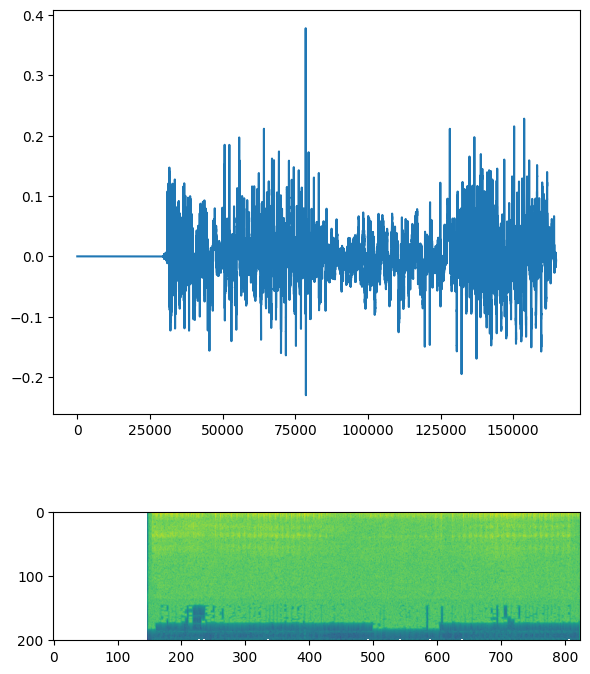

In [ ]:
plot_audio('Purring/cat_coll0133_aug1(1).mp3')

Shape of waveform: torch.Size([2, 40320])
Sample rate of waveform: 44100


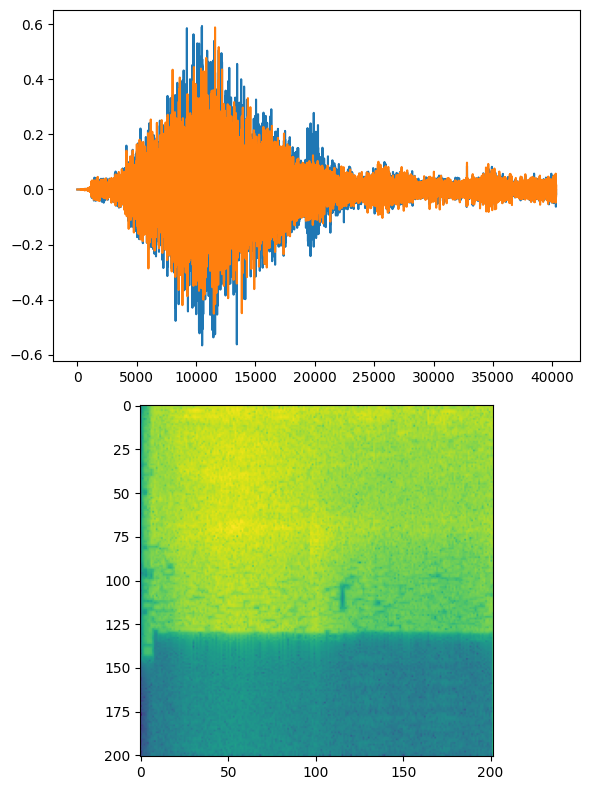

In [ ]:
plot_audio('Hissing/car_extcoll0268.mp3')

Shape of waveform: torch.Size([2, 215424])
Sample rate of waveform: 44100


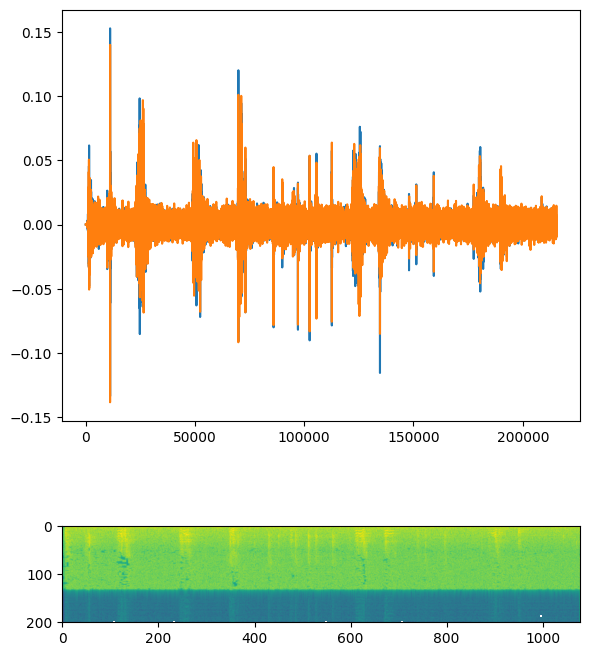

In [ ]:
plot_audio('Chirping/cat_youtube01123.mp3')

# Image dataset

In [ ]:
image_folder_beti = mfccs_path_beti if use_mffc else spectrogram_path_beti
image_folder_kisha = mfccs_path_kisha if use_mffc else spectrogram_path_kisha

In [ ]:
base_width = 224#201
base_height = 224#81

In [ ]:
spec_dataset_beti = datasets.ImageFolder(
    root=image_folder_beti,
    transform=transforms.Compose([
      transforms.Resize((base_width,base_height)),#transforms.Resize((224,224))
      transforms.ToTensor()
    ])
)
print(spec_dataset_beti)

Dataset ImageFolder
    Number of datapoints: 3161
    Root location: /content/drive/MyDrive/COIN Seminar/data/spectrograms_beti
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [ ]:
spec_dataset_kisha = datasets.ImageFolder(
    root=image_folder_kisha,
    transform=transforms.Compose([
      transforms.Resize((base_width,base_height)),
      transforms.ToTensor()
    ])
)
print(spec_dataset_kisha)

Dataset ImageFolder
    Number of datapoints: 1398
    Root location: /content/drive/MyDrive/COIN Seminar/data/spectrograms_kisha
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [ ]:
class_map=spec_dataset_beti.class_to_idx

print("\nClass category and index of the images for model 1: {}\n".format(class_map))


Class category and index of the images for model 1: {'chirp': 0, 'hiss': 1, 'meow': 2, 'purr': 3}



In [ ]:
class_map=spec_dataset_kisha.class_to_idx

print("\nClass category and index of the images for model 2: {}\n".format(class_map))


Class category and index of the images for model 2: {'angry': 0, 'happy': 1, 'sad': 2}



In [ ]:
def create_data_split(dataset):
  #split data to test and train
  #use 80% to train
  train_size = int(0.7 * len(dataset))
  validation_size = int(0.1 * len(dataset))
  test_size = len(dataset) - train_size - validation_size

  generator = torch.Generator().manual_seed(42)
  train, test, val = torch.utils.data.random_split(dataset, [train_size, test_size, validation_size], generator=generator)

  return train, test, val

In [ ]:
train_dataset_beti, test_dataset_beti, val_dataset_beti = create_data_split(spec_dataset_beti)
print("Training size Model 1:", len(train_dataset_beti))
print("Testing size Model 1:",len(test_dataset_beti))
print("Validation size Model 1:",len(val_dataset_beti))

Training size Model 1: 2212
Testing size Model 1: 633
Validation size Model 1: 316


In [ ]:
train_dataset_kisha, test_dataset_kisha, val_dataset_kisha = create_data_split(spec_dataset_kisha)
print("Training size Model 2:", len(train_dataset_kisha))
print("Testing size Model 2:",len(test_dataset_kisha))
print("Validation size Model 2:",len(val_dataset_kisha))

Training size Model 2: 978
Testing size Model 2: 281
Validation size Model 2: 139


In [ ]:
train_dataloader_beti = torch.utils.data.DataLoader(
    train_dataset_beti,
    batch_size=32,
    num_workers=2,
    shuffle=True
)

test_dataloader_beti = torch.utils.data.DataLoader(
    test_dataset_beti,
    batch_size=32,
    num_workers=2,
    shuffle=True
)

In [ ]:
train_dataloader_kisha = torch.utils.data.DataLoader(
    train_dataset_kisha,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

test_dataloader_kisha = torch.utils.data.DataLoader(
    test_dataset_kisha,
    batch_size=15,
    num_workers=2,
    shuffle=True
)

In [ ]:
td = train_dataloader_beti.dataset[0][0][0][0]
print(td)

tensor([0.3255, 0.2784, 0.1804, 0.1294, 0.1451, 0.1490, 0.1412, 0.1333, 0.1255,
        0.1216, 0.1255, 0.1294, 0.1216, 0.1176, 0.1216, 0.1255, 0.1216, 0.1176,
        0.1216, 0.1216, 0.1216, 0.1255, 0.1216, 0.1176, 0.1333, 0.1529, 0.1490,
        0.1412, 0.1294, 0.1216, 0.1176, 0.1216, 0.1255, 0.1333, 0.1373, 0.1333,
        0.1333, 0.1333, 0.1294, 0.1255, 0.1216, 0.1255, 0.1255, 0.1216, 0.1216,
        0.1294, 0.1373, 0.1333, 0.1294, 0.1294, 0.1294, 0.1294, 0.1294, 0.1373,
        0.1451, 0.1373, 0.1294, 0.1255, 0.1176, 0.1255, 0.1373, 0.1569, 0.1804,
        0.1647, 0.1412, 0.1333, 0.1294, 0.1373, 0.1529, 0.1569, 0.1608, 0.1529,
        0.1412, 0.1373, 0.1373, 0.1333, 0.1216, 0.1255, 0.1412, 0.1451, 0.1294,
        0.1176, 0.1255, 0.1294, 0.1255, 0.1255, 0.1216, 0.1216, 0.1216, 0.1216,
        0.1216, 0.1216, 0.1529, 0.1804, 0.1529, 0.1216, 0.1216, 0.1176, 0.1333,
        0.1490, 0.1373, 0.1216, 0.1216, 0.1294, 0.1255, 0.1216, 0.1216, 0.1216,
        0.1216, 0.1176, 0.1176, 0.1176, 

# Convolutional Neural Network

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


## Model Architecture

In [ ]:
resnet18 = models.resnet18(pretrained=True)
resnet18_features = nn.Sequential(*(list(resnet18.children())[:-1]))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 164MB/s]


In [ ]:
class ResCNNet(nn.Module):
  def __init__(self, n_output=1, freeze=True):
    super().__init__()
    self.resnet = resnet18_features
    if freeze:
      self.freeze()
    self.l1 = nn.Linear(512, n_output)

  def forward(self, x):
    x = self.resnet(x).squeeze()
    return self.l1(x)

  def freeze(self):
    for param in self.resnet.parameters():
      param.requires_grad = False


In [ ]:
class CNNet(nn.Module):
    def __init__(self, n_output=1, conv_kernel_size=5, conv_stride=1, pool_kernel_size=2, pool_stride=2, l1=64, l2=50):
        super().__init__()
        ##self.resnet = resnet18_features
        ##self.conv1 = nn.Conv2d(512, 32, kernel_size=3, padding=1)
        self.conv_kernel_size = conv_kernel_size
        self.conv_stride = conv_stride
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride

        self.conv1 = nn.Conv2d(3, 32, kernel_size=self.conv_kernel_size, stride=self.conv_stride)

        (width, height) = self.update_shape(base_width, base_height)
        (width, height) = self.update_shape(width, height, is_pool=True)

        self.conv2 = nn.Conv2d(32, l1, kernel_size=self.conv_kernel_size, stride=self.conv_stride)

        (width, height) = self.update_shape(width, height)
        (width, height) = self.update_shape(width, height, is_pool=True)

        self.conv2_drop = nn.Dropout2d()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(width * height * l1, l2)
        self.fc2 = nn.Linear(l2, n_output)
        #self.fc3 = nn.Linear(l2, n_output)


    def forward(self, x):
        ##x = self.resnet(x)
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=self.pool_kernel_size, stride=self.pool_stride)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, kernel_size=self.pool_kernel_size, stride=self.pool_stride)
        x = F.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.relu(x)
        #x = self.fc3(x)
        #x = F.relu(x)
        return F.log_softmax(x,dim=1)

    def update_shape(self, width, height, is_pool=False):
        kernel_size = self.pool_kernel_size if is_pool else self.conv_kernel_size
        stride = self.pool_stride if is_pool else self.conv_stride

        width = int(((width - kernel_size) / stride) + 1)
        height = int(((height - kernel_size) / stride) + 1)

        return (width, height)



## Train and Test functions

In [ ]:
def train_catmotion(dataloader, model, optimizer, cost):
    model.train()
    size = len(dataloader.dataset)

    for batch, (X, Y) in tqdm(enumerate(dataloader), total=len(dataloader)):

        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = cost(pred, Y)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')


def test_catmotion(dataloader, model, cost, verbose=0):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for batch, (X, Y) in tqdm(enumerate(dataloader), total=len(dataloader)):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)

            test_loss += cost(pred, Y).item()
            correct += (pred.argmax(1)==Y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    if verbose != 0:
      print(f'\nTest Error:\nacc: {(100*correct):>0.1f}%, avg loss: {test_loss:>8f}\n')
    return test_loss, correct

## Hyperparameter tuning

In [ ]:
def tune_catmotion(config, num_classes, trainset, valset, epochs):
  model = CNNet(
      n_output = num_classes,
      conv_kernel_size = config["conv_kernel_size"],
      conv_stride = config["conv_stride"],
      pool_kernel_size = config["pool_kernel_size"],
      pool_stride = config["pool_stride"],
      l1 = config["l1"],
      l2 = config["l2"]

  )

  device = "cpu"
  if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
      model = nn.DataParallel(model)
  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
  criterion = torch.nn.CrossEntropyLoss()

  try:
    checkpoint = train.get_checkpoint()

    if checkpoint:
      checkpoint_state = checkpoint.to_dict()
      start_epoch = checkpoint_state["epoch"]
      model.load_state_dict(checkpoint_state["net_state_dict"])
      optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
      start_epoch = 0
  except:
    start_epoch = 0

  trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=8
  )
  valloader = torch.utils.data.DataLoader(
    valset, batch_size=int(config["batch_size"]), shuffle=True, num_workers=8
  )

  for epoch in range(start_epoch, epochs):
    train_catmotion(trainloader, model, optimizer, criterion)
    loss, acc = test_catmotion(valloader, model, criterion)
    checkpoint_data = {
      "epoch": epoch,
      "net_state_dict": model.state_dict(),
      "optimizer_state_dict": optimizer.state_dict(),
    }

    if not os.path.exists(tmp_path):
      os.mkdir(tmp_path)

    with open(os.path.join(tmp_path, 'data.pkl'), 'wb') as fp:
      pickle.dump(checkpoint_data, fp)

    checkpoint = Checkpoint.from_directory(tmp_path)
    #checkpoint = Checkpoint.from_dict(checkpoint_data)

    train.report(
      {"loss": loss, "accuracy": acc},
      checkpoint=checkpoint,
    )
  print("Finished Training")

In [ ]:
config = {
  "l1": tune.choice([2**i for i in range(9)]),
  "l2": tune.choice([2**i for i in range(9)]),
  "conv_kernel_size": tune.choice([i for i in range(3,6)]),
  "conv_stride": tune.choice([i for i in range(1,3)]),
  "pool_kernel_size": tune.choice([i for i in range(2,4)]),
  "pool_stride": tune.choice([i for i in range(2,4)]),
  "lr": tune.loguniform(1e-4, 1e-1),
  "batch_size": tune.choice([2, 4, 8, 16]),
}

max_num_epochs = 10
num_samples = 10
gpus_per_trial = 0

scheduler = ASHAScheduler(
  metric="loss",
  mode="min",
  max_t=max_num_epochs,
  grace_period=1,
  reduction_factor=2,
)

result = tune.run(
  partial(tune_catmotion, num_classes=4, trainset=train_dataset_kisha, valset=val_dataset_kisha, epochs=5),
  #partial(tune_catmotion, num_classes=4, trainset=train_dataset_beti, valset=val_dataset_beti, epochs=5),
  resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
  config=config,
  num_samples=num_samples,
  scheduler=scheduler,
)

best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")

In [ ]:
best_trial.config

{'l1': 64,
 'l2': 64,
 'conv_kernel_size': 5,
 'conv_stride': 2,
 'pool_kernel_size': 2,
 'pool_stride': 2,
 'lr': 0.0007283594232214701,
 'batch_size': 16}

# Traning model

## Beti

In [ ]:
beti = CNNet(
    n_output=4,
    l1 = best_trial.config["l1"],
    l2 = best_trial.config["l2"],
    conv_kernel_size = best_trial.config["conv_kernel_size"],
    conv_stride = best_trial.config["conv_stride"],
    pool_kernel_size = best_trial.config["pool_kernel_size"],
    pool_stride = best_trial.config["pool_stride"],
).to(device)

In [ ]:
#beti = ResCNNet(n_output=4, freeze=False).to(device) # this is inplace
beti = CNNet(n_output = 4).to(device)
epochs = 50
learning_rate = 0.001#best_trial.config["lr"]

optimizer = torch.optim.Adam(beti.parameters(), lr=learning_rate)
cost = torch.nn.CrossEntropyLoss()

date = time.ctime(time.time())
best_accuracy = 0

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train_catmotion(train_dataloader_beti, beti, optimizer, cost)
    (test_loss, accuracy) = test_catmotion(test_dataloader_beti, beti, cost, verbose=1)

    if accuracy > best_accuracy:
      torch.save(beti.state_dict(), f'{notebook_path}/models/beti_h{epochs}_{date}.pth')
      best_accuracy = accuracy

print('Done!')

Epoch 1
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.367608  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 40.0%, avg loss: 0.041806

Epoch 2
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.384032  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 40.9%, avg loss: 0.040959

Epoch 3
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.410797  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 45.8%, avg loss: 0.038524

Epoch 4
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.176077  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 43.8%, avg loss: 0.038091

Epoch 5
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.104219  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 37.4%, avg loss: 0.039187

Epoch 6
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.273929  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 56.7%, avg loss: 0.033323

Epoch 7
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.011809  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 54.8%, avg loss: 0.032551

Epoch 8
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.117084  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 57.3%, avg loss: 0.031440

Epoch 9
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.147781  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 61.1%, avg loss: 0.030876

Epoch 10
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.089545  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 59.7%, avg loss: 0.030893

Epoch 11
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.249051  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 64.6%, avg loss: 0.029404

Epoch 12
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.713713  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 64.6%, avg loss: 0.026634

Epoch 13
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.787762  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 67.9%, avg loss: 0.029030

Epoch 14
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.833286  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 64.8%, avg loss: 0.027084

Epoch 15
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.039455  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 63.8%, avg loss: 0.027306

Epoch 16
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.660038  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 63.7%, avg loss: 0.027681

Epoch 17
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.970966  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 66.2%, avg loss: 0.027647

Epoch 18
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.861343  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 66.5%, avg loss: 0.026263

Epoch 19
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.974984  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 67.0%, avg loss: 0.026791

Epoch 20
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.995552  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 69.2%, avg loss: 0.025858

Epoch 21
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.095637  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 67.6%, avg loss: 0.025398

Epoch 22
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.809181  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 68.2%, avg loss: 0.025869

Epoch 23
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.918060  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 70.0%, avg loss: 0.023958

Epoch 24
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 1.066588  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 71.1%, avg loss: 0.023990

Epoch 25
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.682195  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 71.7%, avg loss: 0.023351

Epoch 26
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.656773  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 76.9%, avg loss: 0.021988

Epoch 27
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.564360  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 78.4%, avg loss: 0.020213

Epoch 28
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.753408  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 77.9%, avg loss: 0.021299

Epoch 29
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.824466  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 79.3%, avg loss: 0.019556

Epoch 30
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.646881  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 74.1%, avg loss: 0.021583

Epoch 31
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.637224  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 80.4%, avg loss: 0.018509

Epoch 32
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.459875  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 80.4%, avg loss: 0.017818

Epoch 33
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.584839  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 80.3%, avg loss: 0.018122

Epoch 34
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.467778  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 81.5%, avg loss: 0.016522

Epoch 35
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.596829  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 80.6%, avg loss: 0.017710

Epoch 36
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.894242  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 82.0%, avg loss: 0.016830

Epoch 37
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.412074  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 80.9%, avg loss: 0.018081

Epoch 38
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.583785  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 82.5%, avg loss: 0.016670

Epoch 39
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.566371  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 82.6%, avg loss: 0.017439

Epoch 40
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.298905  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 83.3%, avg loss: 0.016400

Epoch 41
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.383844  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 82.8%, avg loss: 0.016501

Epoch 42
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.585534  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 83.1%, avg loss: 0.017249

Epoch 43
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.645669  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 81.8%, avg loss: 0.015648

Epoch 44
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.399094  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 80.7%, avg loss: 0.019136

Epoch 45
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.190377  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 83.7%, avg loss: 0.015925

Epoch 46
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.203033  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 83.4%, avg loss: 0.015170

Epoch 47
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.626882  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 83.1%, avg loss: 0.015191

Epoch 48
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.383916  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 83.7%, avg loss: 0.014457

Epoch 49
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.265222  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 85.0%, avg loss: 0.014150

Epoch 50
-------------------------------


  0%|          | 0/70 [00:00<?, ?it/s]

loss: 0.134629  [    0/ 2212]


  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 84.5%, avg loss: 0.014731

Done!


## Kisha

In [ ]:
kisha = CNNet(
    n_output=3,
    #l1 = 8,#best_trial.config["l1"],
    #l2 = 32,#best_trial.config["l2"],
    #conv_kernel_size = 3,#best_trial.config["conv_kernel_size"],
    #conv_stride = 2,#best_trial.config["conv_stride"],
    #pool_kernel_size = 2,#best_trial.config["pool_kernel_size"],
    #pool_stride = 3#best_trial.config["pool_stride"],
).to(device)

In [ ]:
kisha = ResCNNet(n_output=3, freeze=False)
kisha.to(device)
epochs = 50
learning_rate = 0.001#0.00030301142660206764#best_trial.config["lr"]

optimizer = torch.optim.Adam(kisha.parameters(), lr=learning_rate)
cost = torch.nn.CrossEntropyLoss()

date = time.ctime(time.time())
best_accuracy = 0

for t in range(epochs):
    print(f'Epoch {t+1}\n-------------------------------')
    train_catmotion(train_dataloader_kisha, kisha, optimizer, cost)
    (test_loss, accuracy) = test_catmotion(test_dataloader_kisha, kisha, cost, verbose=1)

    if accuracy > best_accuracy:
      torch.save(kisha.state_dict(), f'{notebook_path}/models/kisha_h{epochs}_{date}.pth')
      best_accuracy = accuracy

print('Done!')

Epoch 1
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 1.173699  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 84.7%, avg loss: 0.027282

Epoch 2
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.309347  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 84.7%, avg loss: 0.033548

Epoch 3
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.360029  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 81.5%, avg loss: 0.030022

Epoch 4
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.415186  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 66.9%, avg loss: 0.065599

Epoch 5
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.336645  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 79.4%, avg loss: 0.037416

Epoch 6
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.271300  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 85.4%, avg loss: 0.023182

Epoch 7
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.134512  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 68.3%, avg loss: 0.059390

Epoch 8
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.291411  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 89.3%, avg loss: 0.020421

Epoch 9
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.087237  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 80.4%, avg loss: 0.029665

Epoch 10
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.065229  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 78.3%, avg loss: 0.045186

Epoch 11
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.258794  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.9%, avg loss: 0.026832

Epoch 12
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.101890  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 79.7%, avg loss: 0.041737

Epoch 13
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.041634  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 90.4%, avg loss: 0.020028

Epoch 14
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.306038  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.9%, avg loss: 0.025609

Epoch 15
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.109544  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.2%, avg loss: 0.028634

Epoch 16
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.021284  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 86.1%, avg loss: 0.033121

Epoch 17
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.164383  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.2%, avg loss: 0.036970

Epoch 18
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.163462  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 85.4%, avg loss: 0.030679

Epoch 19
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.015651  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 90.0%, avg loss: 0.018961

Epoch 20
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.030333  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.9%, avg loss: 0.025371

Epoch 21
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.006314  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 88.3%, avg loss: 0.028255

Epoch 22
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.004558  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 83.6%, avg loss: 0.039711

Epoch 23
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.036692  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 79.4%, avg loss: 0.074258

Epoch 24
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.375156  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.2%, avg loss: 0.030145

Epoch 25
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.005316  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 86.1%, avg loss: 0.040035

Epoch 26
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.332552  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 84.0%, avg loss: 0.041342

Epoch 27
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.054901  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 83.3%, avg loss: 0.044221

Epoch 28
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.017836  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 89.0%, avg loss: 0.025412

Epoch 29
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.030551  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.5%, avg loss: 0.031170

Epoch 30
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.029948  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 89.3%, avg loss: 0.030565

Epoch 31
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.043603  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 90.0%, avg loss: 0.031142

Epoch 32
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.000863  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 89.3%, avg loss: 0.029674

Epoch 33
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.034242  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 91.1%, avg loss: 0.030164

Epoch 34
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.001146  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.5%, avg loss: 0.033621

Epoch 35
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.082610  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.9%, avg loss: 0.035039

Epoch 36
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.014296  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.5%, avg loss: 0.043846

Epoch 37
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.018705  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.9%, avg loss: 0.037052

Epoch 38
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.224266  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 90.0%, avg loss: 0.025513

Epoch 39
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.001477  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 90.4%, avg loss: 0.028321

Epoch 40
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.001617  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 82.6%, avg loss: 0.062678

Epoch 41
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.001207  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.2%, avg loss: 0.029540

Epoch 42
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.201951  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 90.0%, avg loss: 0.031287

Epoch 43
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.021502  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 91.8%, avg loss: 0.031530

Epoch 44
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.001371  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 91.1%, avg loss: 0.034712

Epoch 45
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.002536  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.5%, avg loss: 0.038860

Epoch 46
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.003368  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 84.3%, avg loss: 0.039749

Epoch 47
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.016931  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.9%, avg loss: 0.037508

Epoch 48
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.025794  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 87.5%, avg loss: 0.037726

Epoch 49
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.010964  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 89.3%, avg loss: 0.038334

Epoch 50
-------------------------------


  0%|          | 0/66 [00:00<?, ?it/s]

loss: 0.000614  [    0/  978]


  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 89.0%, avg loss: 0.035915

Done!


In [ ]:
date = time.ctime(time.time())
torch.save(kisha.state_dict(), f'{notebook_path}/kisha_h{epochs}_{date}.pth')

# Evaluation

In [ ]:
def build_confusion_matrix_with_metrics(model, dataloader, class_names):
    model.eval()  # Set the model to evaluation mode

    # Iterate through the dataset and collect predictions
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, y_pred = torch.max(outputs, 1)
            y_pred_list.extend(y_pred.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy())

    confusion_mat = confusion_matrix(y_true_list, y_pred_list)
    report = classification_report(y_true_list, y_pred_list, target_names = class_names)

    res = []
    for l in range(0, len(class_names)):
      prec,recall,_,_ = precision_recall_fscore_support(
          np.array(y_true_list)==l,
          np.array(y_pred_list)==l,
          pos_label=True,average=None
      )
      res.append([class_names[l],recall[0],recall[1]])
    return confusion_mat, res


def plot_confusion_matrix(cm, classes):
  plt.figure(figsize=(len(classes), len(classes)))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=classes, yticklabels=classes)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

## Beti

In [ ]:
beti = CNNet(n_output = 4).to(device)
beti.load_state_dict(torch.load(f'{notebook_path}/models/beti.pth'))
beti_classes = ['chirp', 'hiss', 'meow', 'purr']2

In [ ]:
confusion_matrix_beti, metrics_beti = build_confusion_matrix_with_metrics(beti, test_dataloader_beti, beti_classes)

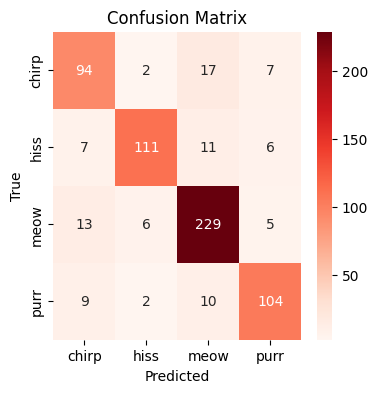

In [ ]:
plot_confusion_matrix(confusion_matrix_beti, beti_classes)

In [ ]:
pd.DataFrame(metrics_beti, columns = ['class','specificity','sensitivity'])

,class,specificity,sensitivity
0,chirp,0.943470,0.783333
1,hiss,0.979920,0.822222
2,meow,0.900000,0.905138
3,purr,0.964567,0.832000


In [ ]:
cost = torch.nn.CrossEntropyLoss()
loss, accuracy = test_catmotion(test_dataloader_beti, beti, cost, verbose = 1)

  0%|          | 0/20 [00:00<?, ?it/s]


Test Error:
acc: 85.0%, avg loss: 0.014157



## Kisha

In [ ]:
kisha = ResCNNet(n_output = 3, freeze = False).to(device)
kisha.load_state_dict(torch.load(f'{notebook_path}/final_models/kisha.pth'))
kisha_classes = ['angry', 'happy', 'sad']

In [ ]:
confusion_matrix_kisha, metrics_kisha = build_confusion_matrix_with_metrics(kisha, test_dataloader_kisha, ['angry', 'happy', 'sad'])

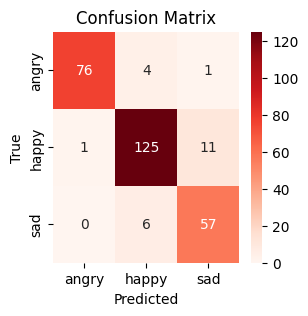

In [ ]:
plot_confusion_matrix(confusion_matrix_kisha, ['angry', 'happy', 'sad'])

In [ ]:
pd.DataFrame(metrics_kisha, columns = ['class','specificity','sensitivity'])

,class,specificity,sensitivity
0,angry,0.995000,0.938272
1,happy,0.930556,0.912409
2,sad,0.944954,0.904762


In [ ]:
cost = torch.nn.CrossEntropyLoss()
test_catmotion(test_dataloader_kisha, kisha, cost, verbose = 1)

  0%|          | 0/19 [00:00<?, ?it/s]


Test Error:
acc: 91.8%, avg loss: 0.031585



(0.03158484867300003, 0.9181494661921709)